In [2]:
import json
from io import StringIO
from popframe.method.urbanisation_level import UrbanisationLevel
from popframe.models.region import Region
import geopandas as gpd
region_model = Region.from_pickle('data/Ленинградская область.pickle')
urbanisation = UrbanisationLevel(region=region_model)

In [3]:
geojson_data = {"geometry":
{"type":"MultiPolygon","coordinates":[[[[30.0059032,59.3540961],[30.0140259,59.3541968],[30.0144851,59.3537473],[30.0171668,59.3511223],[30.015342,59.350238],[30.0138596,59.3495195],[30.0143785,59.3491353],[30.0162724,59.347733],[30.0191619,59.3486876],[30.0208661,59.3471504],[30.0304709,59.3498384],[30.0326995,59.3498646],[30.0352931,59.3498669],[30.0363521,59.3497148],[30.0375074,59.3497531],[30.03943,59.3505102],[30.0394118,59.3508378],[30.0398624,59.3508471],[30.0470199,59.3509127],[30.0470987,59.3509101],[30.0494094,59.3508325],[30.0500785,59.35081],[30.0599024,59.3504801],[30.060686,59.353232],[30.0538542,59.3648126],[30.0461724,59.3637629],[30.0425815,59.3663932],[30.0417092,59.3670321],[30.0409734,59.3671498],[30.0372675,59.3677428],[30.0330454,59.3664227],[30.032496,59.3662509],[30.0287702,59.3650859],[30.0193074,59.367382],[30.0177839,59.3660372],[30.0257876,59.36373],[30.025101,59.3618383],[30.0283411,59.361729],[30.0285771,59.3628334],[30.0349286,59.3629428],[30.034702,59.3620422],[30.0346067,59.3616634],[30.0182345,59.3587545],[30.0179306,59.3589847],[30.0158956,59.3605261],[30.0106814,59.3597059],[30.0099518,59.3581092],[30.0040991,59.357103],[30.0059032,59.3540961]]]]},
"properties":{},"type":"Feature"}

In [4]:
geojson_data = {
                "type": "Feature",
                "properties": {},
                "geometry": {
                    "coordinates": [
                        [
                            [29.982879431084967, 59.363554752593245],
                            [29.982879431084967, 59.322083801173534],
                            [30.109075699649765, 59.322083801173534],
                            [30.109075699649765, 59.363554752593245],
                            [29.982879431084967, 59.363554752593245],
                        ]
                    ],
                    "type": "Polygon"
                }
            }

In [5]:
territories = json.dumps(geojson_data)
territories_gdf = gpd.read_file(StringIO(territories))
territories_gdf.explore()

In [6]:
landuse_data = urbanisation.get_landuse_data(territories_gdf)
landuse_data

Error fetching data for tag filter {'landuse': 'forest'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'wood'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'conservation'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'detached'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'brownfield'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'orchard'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'reservoir'}: No data elements in server response. Check log and query location/tags.
Error fetching data for tag filter {'landuse': 'plant_nursery'}: No data ele

/Users/mvin/Code/PopFrame/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,№ п/п,Название хранимое,ед.изм.,Значение,Источник,Период,geometry
0,1.3.1,Процент застройки жилищным строительством,%,6.570,modeled,2024,"MULTIPOLYGON (((30.01402 59.33217, 30.01157 59..."
1,1.3.2,Процент земель сельскохозяйственного назначения,%,21.109,modeled,2024,"MULTIPOLYGON (((30.02584 59.32335, 30.02442 59..."
2,1.3.3,Процент земель промышленного назначения,%,1.048,modeled,2024,"MULTIPOLYGON (((30.03206 59.32686, 30.02811 59..."
3,1.3.4,"Процент земель, занимаемыми лесными массивами",%,21.932,modeled,2024,"MULTIPOLYGON (((30.00962 59.32212, 30.00978 59..."
4,1.3.5,Процент земель специального назначения,%,10.889,modeled,2024,"MULTIPOLYGON (((30.02251 59.34414, 30.02186 59..."
5,1.3.6,Процент земель населенных пунктов,%,21.242,modeled,2024,"MULTIPOLYGON (((30.03615 59.33653, 30.03612 59..."
6,1.3.8,"Процент земель, занимаемых водным фондом",%,0.800,modeled,2024,"MULTIPOLYGON (((29.99158 59.32592, 29.99166 59..."
7,1.3.9,Территории смежного назначения,%,16.407,modeled,2024,"MULTIPOLYGON (((30.02711 59.32215, 30.02719 59..."


/Users/mvin/Code/PopFrame/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


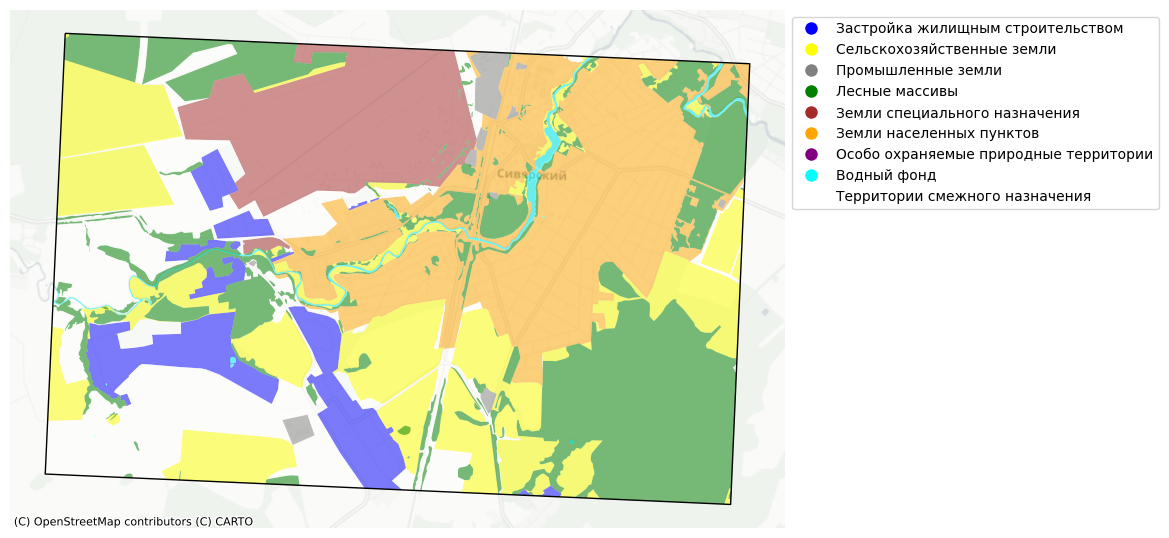

In [7]:
urbanisation.plot_landuse(territories_gdf, landuse_data)